# Musgraves Processing

### Import packages

In [42]:
import aurora
import mt_metadata
import mth5
import pandas as pd
import pathlib
import socket
import warnings

from aurora.config.config_creator import ConfigCreator
from aurora.config import BANDS_TEST_FAST_FILE
from aurora.pipelines.process_mth5 import process_mth5
from aurora.pipelines.run_summary import RunSummary
from aurora.transfer_function.kernel_dataset import KernelDataset
from mth5.mth5 import MTH5
from mt_metadata.transfer_functions.processing.aurora.channel_nomenclature import CHANNEL_MAPS

warnings.filterwarnings('ignore')

In [2]:
from IPython.display import HTML, display

def set_background(color):    
    script = (
        "var cell = this.closest('.jp-CodeCell');"
        "var editor = cell.querySelector('.jp-Editor');"
        "editor.style.background='{}';"
        "this.parentNode.removeChild(this)"
    ).format(color)
    
    display(HTML('<img src onerror="{}" style="display:none">'.format(script)))


### Check versions

In [3]:
print(f"aurora.__version__ {aurora.__version__}")
print(f"mt_metadata.__version__ {mt_metadata.__version__}")
print(f"mth5.__version__ {mth5.__version__}")

aurora.__version__ 0.3.0
mt_metadata.__version__ 0.3.0
mth5.__version__ 0.4.0


### Set some Paths
- this is a little overdone

In [4]:
hostname = socket.gethostname()
print(f"hostname: {hostname}")
if "gadi" in hostname:
    my80_path = pathlib.Path("/g/data/my80")
elif hostname == "namazu":
    my80_path = pathlib.Path("/home/kkappler/data/gadi/g/data/my80")
    
au_scope_mt_collection_path = my80_path.joinpath("AuScope_MT_collection")
auslamp_path = au_scope_mt_collection_path.joinpath("AuScope_AusLAMP")
musgraves_path = auslamp_path.joinpath("Musgraves_APY")
data_dir = musgraves_path
assert data_dir.exists()
#data_dir = pathlib.Path("/home/kkappler/data/gadi/g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY")

hostname: gadi-cpu-bdw-0001.gadi.nci.org.au


# Existing Directory Structure:

The Musgraves dataset is organized by Territory (NT, SA, WA), and within each territory there are levels 0, 1, and 2. 

Use NT as an example to look at the level structure:

There are two folders of interest for this exercise, the MTH5 ones:
- level_0/Concatenated_Time_Series_MTH5_per_run
- level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5

We will abbreviate these as level 0 and 1 for indexing the hdf5s.

### Use pathlinb to index the hd5 files


In [5]:
all_mth5_files = data_dir.rglob("*h5")
all_mth5_files_list = list(all_mth5_files)

In [6]:
num_mth5 = len(all_mth5_files_list)
print(f"Found {num_mth5} h5 files")
# print(list(all_mth5_files))

Found 184 h5 files


### Make a table of these files, extracting reference properties: "level", "territory", "station_id"

In [7]:
levels = num_mth5 * [""]
station_ids = num_mth5 * [""]
territories = num_mth5 * [""]
paths = num_mth5 * [""]

for i_filepath, filepath in enumerate(all_mth5_files_list):
    levels[i_filepath] = str(filepath).split("level_")[1][0]
    station_ids[i_filepath] = filepath.stem
    territories[i_filepath] = str(filepath).split("Musgraves_APY/")[1][0:2]
    paths[i_filepath] = filepath

In [8]:
df_dict = {"level":levels, "territory":territories, "station_id": station_ids, "path":paths}
df = pd.DataFrame(data=df_dict)
df

,level,territory,station_id,path
0,1,WA,WA67,/g/data/my80/AuScope_MT_collection/AuScope_Aus...
1,1,WA,WA66,/g/data/my80/AuScope_MT_collection/AuScope_Aus...
2,1,WA,WA74,/g/data/my80/AuScope_MT_collection/AuScope_Aus...
3,1,WA,WA60,/g/data/my80/AuScope_MT_collection/AuScope_Aus...
4,1,WA,WA44,/g/data/my80/AuScope_MT_collection/AuScope_Aus...
...,...,...,...,...
179,0,SA,SA26W-2,/g/data/my80/AuScope_MT_collection/AuScope_Aus...
180,0,SA,SA344-2,/g/data/my80/AuScope_MT_collection/AuScope_Aus...
181,0,SA,SA273,/g/data/my80/AuScope_MT_collection/AuScope_Aus...
182,0,SA,SA351,/g/data/my80/AuScope_MT_collection/AuScope_Aus...


### Take a look at the distribution of the data

In [9]:
df[["level", "territory",]].value_counts()

level  territory
0      SA           49
1      SA           49
0      WA           41
1      WA           41
0      NT            2
1      NT            2
dtype: int64

### Northern Territory (NT) has only two stations so we can use it for some testing

In [10]:
nt_df = df[(df.territory=="NT") & (df.level=="1")]
nt_df

,level,territory,station_id,path
82,1,NT,SA349,/g/data/my80/AuScope_MT_collection/AuScope_Aus...
83,1,NT,WANT38,/g/data/my80/AuScope_MT_collection/AuScope_Aus...


### Open the mth5 files using a dict for tracking who's who

In [11]:
mth5_objs = {x:MTH5() for x in nt_df.station_id}


In [12]:
for i, row in nt_df.iterrows():
    mth5_objs[row.station_id].open_mth5(row.path, "r")

### Take a gander at the structure

In [13]:
mth5_objs["SA349"]

/:
    |- Group: Experiment
    --------------------
        |- Group: Reports
        -----------------
        |- Group: Standards
        -------------------
            --> Dataset: summary
            ......................
        |- Group: Surveys
        -----------------
            |- Group: AusLAMP_Musgraves
            ---------------------------
                |- Group: Filters
                -----------------
                    |- Group: coefficient
                    ---------------------
                        |- Group: bz_adjustment
                        -----------------------
                        |- Group: gain_b
                        ----------------
                        |- Group: gain_e
                        ----------------
                        |- Group: gain_eonly
                        --------------------
                    |- Group: fap
                    -------------
                    |- Group: fir
                    -------------
 

### Looks like just one run here

In [14]:
mth5_objs["WANT38"]

/:
    |- Group: Experiment
    --------------------
        |- Group: Reports
        -----------------
        |- Group: Standards
        -------------------
            --> Dataset: summary
            ......................
        |- Group: Surveys
        -----------------
            |- Group: AusLAMP_Musgraves
            ---------------------------
                |- Group: Filters
                -----------------
                    |- Group: coefficient
                    ---------------------
                        |- Group: bz_adjustment
                        -----------------------
                        |- Group: gain_b
                        ----------------
                        |- Group: gain_e
                        ----------------
                        |- Group: gain_eonly
                        --------------------
                    |- Group: fap
                    -------------
                    |- Group: fir
                    -------------
 

In [15]:
channel_summaries = {}
for station_id, mth5_obj in mth5_objs.items():
    channel_summary_df = mth5_obj.channel_summary.to_dataframe()
    channel_summaries[station_id] = channel_summary_df

In [16]:
channel_summaries["SA349"]

,survey,station,run,latitude,longitude,elevation,component,start,end,n_samples,sample_rate,measurement_type,azimuth,tilt,units,hdf5_reference,run_hdf5_reference,station_hdf5_reference
0,none,SA349,1,-25.99472,130.49991,646.0,bx,2017-08-20 00:00:00+00:00,2017-10-18 23:59:59.999999+00:00,5184000,1.0,magnetic,0.0,0.0,nT,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
1,none,SA349,1,-25.99472,130.49991,646.0,by,2017-08-20 00:00:00+00:00,2017-10-18 23:59:59.999999+00:00,5184000,1.0,magnetic,90.0,0.0,nT,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
2,none,SA349,1,-25.99472,130.49991,646.0,bz,2017-08-20 00:00:00+00:00,2017-10-18 23:59:59.999999+00:00,5184000,1.0,magnetic,0.0,0.0,nT,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
3,none,SA349,1,-25.99472,130.49991,646.0,ex,2017-08-20 00:00:00+00:00,2017-10-18 23:59:59.999999+00:00,5184000,1.0,electric,0.0,0.0,mV/m,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
4,none,SA349,1,-25.99472,130.49991,646.0,ey,2017-08-20 00:00:00+00:00,2017-10-18 23:59:59.999999+00:00,5184000,1.0,electric,90.0,0.0,mV/m,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>


In [17]:
channel_summaries["WANT38"]

,survey,station,run,latitude,longitude,elevation,component,start,end,n_samples,sample_rate,measurement_type,azimuth,tilt,units,hdf5_reference,run_hdf5_reference,station_hdf5_reference
0,none,WANT38,1,-25.00617,129.00358,731.0,bx,2016-10-25 00:00:00+00:00,2016-11-14 23:59:59.999999+00:00,1814400,1.0,magnetic,0.0,0.0,nT,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
1,none,WANT38,1,-25.00617,129.00358,731.0,by,2016-10-25 00:00:00+00:00,2016-11-14 23:59:59.999999+00:00,1814400,1.0,magnetic,90.0,0.0,nT,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
2,none,WANT38,1,-25.00617,129.00358,731.0,bz,2016-10-25 00:00:00+00:00,2016-11-14 23:59:59.999999+00:00,1814400,1.0,magnetic,0.0,0.0,nT,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
3,none,WANT38,1,-25.00617,129.00358,731.0,ex,2016-10-25 00:00:00+00:00,2016-11-14 23:59:59.999999+00:00,1814400,1.0,electric,0.0,0.0,mV/m,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
4,none,WANT38,1,-25.00617,129.00358,731.0,ey,2016-10-25 00:00:00+00:00,2016-11-14 23:59:59.999999+00:00,1814400,1.0,electric,90.0,0.0,mV/m,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>


### We can see that SA349 is from 2017, and WANT38 is from 2016, so we cannot do RR processing here.

In [18]:
for station_id, mth5_obj in mth5_objs.items():
    print(f"MTH5 file version is {mth5_obj._MTH5__file_version}")

MTH5 file version is 0.2.0
MTH5 file version is 0.2.0


### Close the mth5s

In [19]:
for station_id, mth5_obj in mth5_objs.items():
    mth5_obj.close_mth5()

2023-10-22T07:21:01.087397+1100 | INFO | mth5.mth5 | close_mth5 | Flushing and closing /g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY/NT/level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5/SA349.h5
2023-10-22T07:21:01.089049+1100 | INFO | mth5.mth5 | close_mth5 | Flushing and closing /g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY/NT/level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5/WANT38.h5


### Try processing stations individually: 

In [20]:
i_row = 0
row = nt_df.iloc[i_row]
row

level                                                         1
territory                                                    NT
station_id                                                SA349
path          /g/data/my80/AuScope_MT_collection/AuScope_Aus...
Name: 82, dtype: object

In [32]:
m = MTH5()
m.open_mth5(row.path, 'r')

# <WORKAROUND 1>: 
- Survey is "none" in the channel summary, yet it is stored as "AusLAMP_Musgraves" in the MTH5 hierarchy, 
- similarly, the first run is called "1" in the channel summary, but it is "001" in the MTH5 hierarchy,
- this is because these files are old.
- For now we need to add some info to the channel summary

In [33]:
musgraves_survey = m.get_survey("AusLAMP_Musgraves")
musgraves_survey


set_background("orange")

In [34]:
musgraves_survey.metadata
# musgraves_survey.groups_list

{
    "survey": {
        "acquired_by.author": "Bruce Goleby",
        "acquired_by.comments": "bruce.goleby@opmconsulting.com.au",
        "acquired_by.organization": "OPM consulting Australia",
        "citation_dataset.doi": null,
        "citation_journal.doi": "https://doi.org/10.1186/s40623-020-01223-0",
        "comments": "No comments",
        "country": [
            "Australia"
        ],
        "datum": "WGS84",
        "funding_source.organization": [
            "AuScope"
        ],
        "geographic_name": null,
        "hdf5_reference": "<HDF5 object reference>",
        "id": null,
        "mth5_type": "Survey",
        "name": "SA AusLAMP - Musgraves / APY",
        "northwest_corner.latitude": -25.99472,
        "northwest_corner.longitude": 130.49991,
        "project": "AusLAMP",
        "project_lead.author": "Graham Heinson",
        "project_lead.email": "graham.heinson@adelaide.edu.au",
        "project_lead.organization": "Adelaide University, School of Ph

In [35]:
station_obj = m.get_station("SA349", survey="AusLAMP_Musgraves")
station_obj

/Experiment/Surveys/AusLAMP_Musgraves/Stations/SA349:
    |- Group: 001
    -------------
        --> Dataset: bx
        .................
        --> Dataset: by
        .................
        --> Dataset: bz
        .................
        --> Dataset: ex
        .................
        --> Dataset: ey
        .................
    |- Group: Transfer_Functions
    ----------------------------

In [36]:
run_001 = station_obj.get_run("001")
run_001

/Experiment/Surveys/AusLAMP_Musgraves/Stations/SA349/001:
    --> Dataset: bx
    .................
    --> Dataset: by
    .................
    --> Dataset: bz
    .................
    --> Dataset: ex
    .................
    --> Dataset: ey
    .................

In [37]:
m.close_mth5()

2023-10-22T07:21:37.878118+1100 | INFO | mth5.mth5 | close_mth5 | Flushing and closing /g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY/NT/level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5/SA349.h5


# </WORKAROUND 1> -- Hopefully remove before workshop

We can see that there is no survey name in the channel summary, but 

In [27]:
mth5_run_summary = RunSummary()
mth5_run_summary.from_mth5s([row.path,])
run_summary = mth5_run_summary.clone()
run_summary.mini_summary
run_summary.df

2023-10-22T07:21:02.391763+1100 | INFO | mth5.mth5 | close_mth5 | Flushing and closing /g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY/NT/level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5/SA349.h5


,survey,station_id,run_id,start,end,sample_rate,input_channels,output_channels,channel_scale_factors,valid,mth5_path
0,none,SA349,1,2017-08-20 00:00:00+00:00,2017-10-18 23:59:59.999999+00:00,1.0,"[bx, by]","[bz, ex, ey]","{'bx': 1.0, 'by': 1.0, 'bz': 1.0, 'ex': 1.0, '...",True,/g/data/my80/AuScope_MT_collection/AuScope_Aus...


# TODO: PACK BOTH FILES INTO RUN SUMMARY TO ILLUSTRATE HOW INVALUID RR IS HANDLED IN AURORA

In [28]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, row.station_id, )
kernel_dataset.mini_summary

,survey,station_id,run_id,start,end,duration
0,none,SA349,1,2017-08-20 00:00:00+00:00,2017-10-18 23:59:59.999999+00:00,5.184000e+06


In [29]:
set_background("orange")
kernel_dataset.df

,survey,station_id,run_id,start,end,sample_rate,input_channels,output_channels,channel_scale_factors,valid,mth5_path,remote,duration,fc
0,none,SA349,1,2017-08-20 00:00:00+00:00,2017-10-18 23:59:59.999999+00:00,1.0,"[bx, by]","[bz, ex, ey]","{'bx': 1.0, 'by': 1.0, 'bz': 1.0, 'ex': 1.0, '...",True,/g/data/my80/AuScope_MT_collection/AuScope_Aus...,False,5.184000e+06,False


In [30]:
set_background("orange")

kernel_dataset.df["survey"] = "AusLAMP_Musgraves"
kernel_dataset.df["run_id"] = "001"
kernel_dataset.df

,survey,station_id,run_id,start,end,sample_rate,input_channels,output_channels,channel_scale_factors,valid,mth5_path,remote,duration,fc
0,AusLAMP_Musgraves,SA349,001,2017-08-20 00:00:00+00:00,2017-10-18 23:59:59.999999+00:00,1.0,"[bx, by]","[bz, ex, ey]","{'bx': 1.0, 'by': 1.0, 'bz': 1.0, 'ex': 1.0, '...",True,/g/data/my80/AuScope_MT_collection/AuScope_Aus...,False,5.184000e+06,False


### Make a Config file:
- just use a few bands to show it runs (BANDS_TEST_FAST_FILE)
- Note we need to set the nomenclature


In [38]:

cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset,
                                       emtf_band_file=BANDS_TEST_FAST_FILE)
config.channel_nomenclature.keyword = "musgraves"
config.set_default_input_output_channels()

/home/005/kk9397/software/irismt/aurora/aurora/config/emtf_band_setup/bs_test_fast.cfg
OK


In [39]:
# cc = ConfigCreator()
# config = cc.create_from_kernel_dataset(kernel_dataset, )
# config.channel_nomenclature.keyword = "musgraves"
# config.set_default_input_output_channels()
# #config.channel_nomenclature = CHANNEL_MAPS["musgraves"]
# cfg_json = config.to_json()

In [40]:
config

{
    "processing": {
        "band_setup_file": "/home/005/kk9397/software/irismt/aurora/aurora/config/emtf_band_setup/bs_test_fast.cfg",
        "band_specification_style": "EMTF",
        "channel_nomenclature.ex": "ex",
        "channel_nomenclature.ey": "ey",
        "channel_nomenclature.hx": "bx",
        "channel_nomenclature.hy": "by",
        "channel_nomenclature.hz": "bz",
        "decimations": [
            {
                "decimation_level": {
                    "anti_alias_filter": "default",
                    "bands": [
                        {
                            "band": {
                                "center_averaging_type": "geometric",
                                "closed": "left",
                                "decimation_level": 0,
                                "frequency_max": 0.05859375,
                                "frequency_min": 0.04296875,
                                "index_max": 7,
                                "index_min"

In [26]:
#config.channel_nomenclature = {"}

In [31]:
# get a list of territory codes
territory_codes = df.territory.unique().tolist()
territory_codes.sort()
territory_codes

['NT', 'SA', 'WA']

('AusLAMP_Musgraves', 'SA349', '001', Timestamp('2017-08-20 00:00:00+0000', tz='UTC'))
              survey station_id run_id                     start  \
0  AusLAMP_Musgraves      SA349    001 2017-08-20 00:00:00+00:00   
1  AusLAMP_Musgraves      SA349    001 2017-08-20 00:00:00+00:00   
2  AusLAMP_Musgraves      SA349    001 2017-08-20 00:00:00+00:00   
3  AusLAMP_Musgraves      SA349    001 2017-08-20 00:00:00+00:00   

                               end input_channels output_channels  \
0 2017-10-18 23:59:59.999999+00:00       [bx, by]    [bz, ex, ey]   
1 2017-10-18 23:59:59.999999+00:00       [bx, by]    [bz, ex, ey]   
2 2017-10-18 23:59:59.999999+00:00       [bx, by]    [bz, ex, ey]   
3 2017-10-18 23:59:59.999999+00:00       [bx, by]    [bz, ex, ey]   

                               channel_scale_factors  valid  \
0  {'bx': 1.0, 'by': 1.0, 'bz': 1.0, 'ex': 1.0, '...   True   
1  {'bx': 1.0, 'by': 1.0, 'bz': 1.0, 'ex': 1.0, '...   True   
2  {'bx': 1.0, 'by': 1.0, 'bz': 1.0, 

/home/005/kk9397/software/irismt/aurora/aurora/transfer_function/regression/m_estimator.py:268: RuntimeWarning: overflow encountered in exp
  t = -np.exp(self.u0 * (r - self.u0))
/home/005/kk9397/software/irismt/aurora/aurora/transfer_function/regression/m_estimator.py:275: RuntimeWarning: overflow encountered in multiply
  t = self.u0 * (t * r)
/home/005/kk9397/software/irismt/aurora/aurora/transfer_function/regression/m_estimator.py:276: RuntimeWarning: invalid value encountered in multiply
  t = w * (1 + t)


Processing band 19.929573s


/home/005/kk9397/software/irismt/aurora/aurora/transfer_function/regression/m_estimator.py:268: RuntimeWarning: overflow encountered in exp
  t = -np.exp(self.u0 * (r - self.u0))
/home/005/kk9397/software/irismt/aurora/aurora/transfer_function/regression/m_estimator.py:275: RuntimeWarning: overflow encountered in multiply
  t = self.u0 * (t * r)
/home/005/kk9397/software/irismt/aurora/aurora/transfer_function/regression/m_estimator.py:276: RuntimeWarning: invalid value encountered in multiply
  t = w * (1 + t)


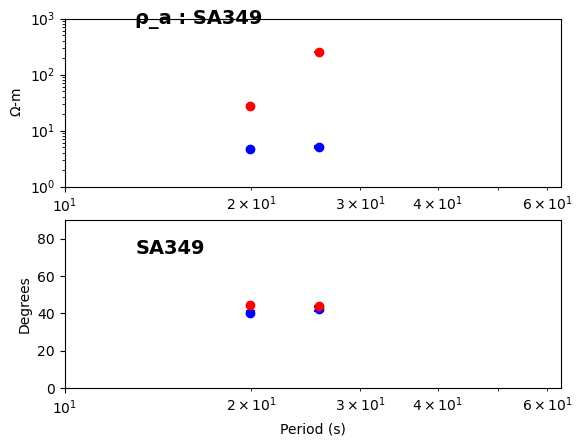

DECIMATION LEVEL 1
DATASET DF UPDATED
WARNING Run ID in dataset_df does not match run_obj
WARNING Forcing run metadata to match dataset_df
WARNING UNEXPECTED CHANNEL WITH NO FILTERS
WARNING UNEXPECTED CHANNEL WITH NO FILTERS
WARNING UNEXPECTED CHANNEL WITH NO FILTERS
WARNING UNEXPECTED CHANNEL WITH NO FILTERS
WARNING UNEXPECTED CHANNEL WITH NO FILTERS
Skip saving FCs. dec_level_config.save_fc =  False
Processing band 102.915872s


/home/005/kk9397/software/irismt/aurora/aurora/transfer_function/regression/m_estimator.py:268: RuntimeWarning: overflow encountered in exp
  t = -np.exp(self.u0 * (r - self.u0))
/home/005/kk9397/software/irismt/aurora/aurora/transfer_function/regression/m_estimator.py:276: RuntimeWarning: invalid value encountered in multiply
  t = w * (1 + t)
/home/005/kk9397/software/irismt/aurora/aurora/transfer_function/regression/m_estimator.py:275: RuntimeWarning: overflow encountered in multiply
  t = self.u0 * (t * r)
/home/005/kk9397/software/irismt/aurora/aurora/transfer_function/regression/m_estimator.py:268: RuntimeWarning: overflow encountered in exp
  t = -np.exp(self.u0 * (r - self.u0))
/home/005/kk9397/software/irismt/aurora/aurora/transfer_function/regression/m_estimator.py:276: RuntimeWarning: invalid value encountered in multiply
  t = w * (1 + t)
/home/005/kk9397/software/irismt/aurora/aurora/transfer_function/regression/m_estimator.py:275: RuntimeWarning: overflow encountered in m

Processing band 85.631182s


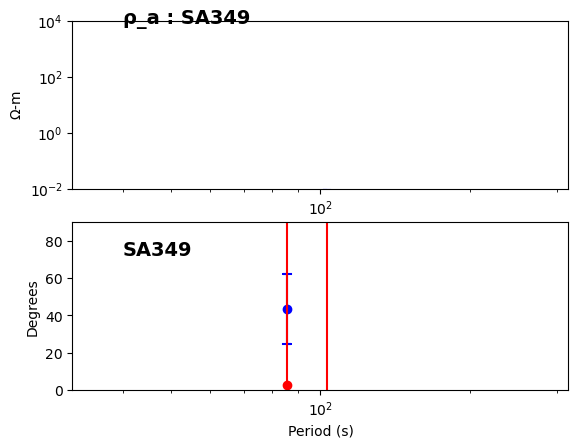

DECIMATION LEVEL 2
DATASET DF UPDATED
WARNING Run ID in dataset_df does not match run_obj
WARNING Forcing run metadata to match dataset_df
WARNING UNEXPECTED CHANNEL WITH NO FILTERS
WARNING UNEXPECTED CHANNEL WITH NO FILTERS
WARNING UNEXPECTED CHANNEL WITH NO FILTERS
WARNING UNEXPECTED CHANNEL WITH NO FILTERS
WARNING UNEXPECTED CHANNEL WITH NO FILTERS
Skip saving FCs. dec_level_config.save_fc =  False
Processing band 411.663489s
Processing band 342.524727s


/home/005/kk9397/software/irismt/aurora/aurora/transfer_function/regression/m_estimator.py:268: RuntimeWarning: overflow encountered in exp
  t = -np.exp(self.u0 * (r - self.u0))
/home/005/kk9397/software/irismt/aurora/aurora/transfer_function/regression/m_estimator.py:276: RuntimeWarning: invalid value encountered in multiply
  t = w * (1 + t)
/home/005/kk9397/software/irismt/aurora/aurora/transfer_function/regression/m_estimator.py:268: RuntimeWarning: overflow encountered in exp
  t = -np.exp(self.u0 * (r - self.u0))
/home/005/kk9397/software/irismt/aurora/aurora/transfer_function/regression/m_estimator.py:276: RuntimeWarning: invalid value encountered in multiply
  t = w * (1 + t)
/home/005/kk9397/software/irismt/aurora/aurora/transfer_function/regression/m_estimator.py:275: RuntimeWarning: overflow encountered in multiply
  t = self.u0 * (t * r)


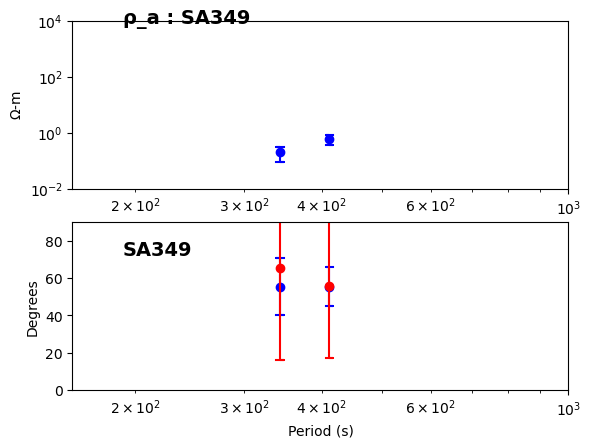

DECIMATION LEVEL 3
DATASET DF UPDATED
WARNING Run ID in dataset_df does not match run_obj
WARNING Forcing run metadata to match dataset_df
WARNING UNEXPECTED CHANNEL WITH NO FILTERS
WARNING UNEXPECTED CHANNEL WITH NO FILTERS
WARNING UNEXPECTED CHANNEL WITH NO FILTERS
WARNING UNEXPECTED CHANNEL WITH NO FILTERS
WARNING UNEXPECTED CHANNEL WITH NO FILTERS
Skip saving FCs. dec_level_config.save_fc =  False
Processing band 1514.701336s
Processing band 1042.488956s


/home/005/kk9397/software/irismt/aurora/aurora/transfer_function/regression/m_estimator.py:268: RuntimeWarning: overflow encountered in exp
  t = -np.exp(self.u0 * (r - self.u0))
/home/005/kk9397/software/irismt/aurora/aurora/transfer_function/regression/m_estimator.py:276: RuntimeWarning: invalid value encountered in multiply
  t = w * (1 + t)
/home/005/kk9397/software/irismt/aurora/aurora/transfer_function/regression/m_estimator.py:268: RuntimeWarning: overflow encountered in exp
  t = -np.exp(self.u0 * (r - self.u0))
/home/005/kk9397/software/irismt/aurora/aurora/transfer_function/regression/m_estimator.py:276: RuntimeWarning: invalid value encountered in multiply
  t = w * (1 + t)


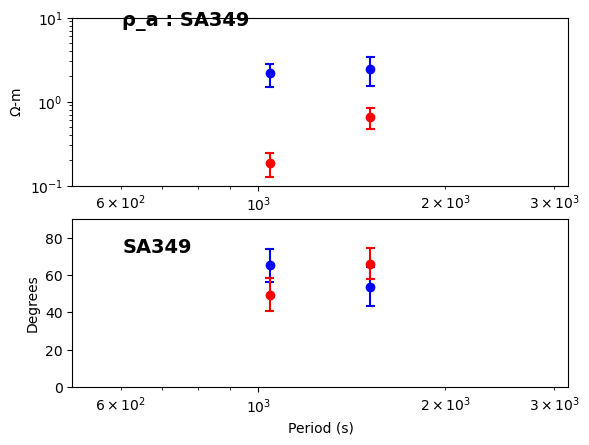

Unexpected key AusLAMP_Musgraves not found in survey_metadataUnexpected key AusLAMP_Musgraves not found in survey_metadata WARNING -- Maybe old MTH5 -- trying to use key '0'
2023-10-22T07:23:32.289190+1100 | INFO | mth5.mth5 | close_mth5 | Flushing and closing /g/data/my80/AuScope_MT_collection/AuScope_AusLAMP/Musgraves_APY/NT/level_1/Concatenated_Resampled_Rotated_Time_Series_MTH5/SA349.h5


In [41]:
show_plot = True
tf_cls = process_mth5(config,
                    kernel_dataset,
                    units="MT",
                    show_plot=show_plot,
                    z_file_path=None,
                )

It can't find "1" which means it 

In [43]:
xml_file_name = "happy.xml"
tf_cls.write(fn=xml_file_name, file_type="emtfxml")

EMTFXML(station='SA349', latitude=-25.99, longitude=130.50, elevation=646.00)

In [44]:
tf_cls.transfer_function

<xarray.DataArray 'transfer_function' (period: 8, output: 3, input: 2)>
array([[[-6.17588000e-02+3.06163526e-02j,
         -8.29122367e-01-7.04632086e-01j],
        [ 1.87913342e+00+1.84097778e+00j,
          2.77784049e+00+2.39302520e+00j],
        [-8.65202672e-01-6.03602620e-03j,
          2.29808852e-01+1.15812840e-02j]],

       [[-1.12011183e-01+8.00739025e-02j,
         -7.41432231e-01-6.72775692e-01j],
        [ 5.08141185e+00+4.89012908e+00j,
          1.70458391e+00+1.16886533e+00j],
        [-1.31016521e-01-2.79932677e-02j,
         -1.51866861e-03+1.98481960e-02j]],

       [[ 1.82753123e-04+8.55454379e-06j,
         -1.06678489e-02-1.01453711e-02j],
        [-2.01361590e-04-1.05715897e-05j,
          2.16769782e-02+1.21404870e-02j],
        [ 9.90084195e-04-2.62721988e-03j,
          2.41140560e-01-7.47334935e-02j]],
...
       [[ 1.96609601e-04-5.20371483e-04j,
         -4.76371371e-02-6.92949645e-02j],
        [ 1.83845373e-03+2.70124897e-03j,
          2.20914746e-01+2.16678936e-01j],
        [ 2.69480370e-02-2.95545255e-03j,
         -9.36236596e-02-2.92867073e-02j]],

       [[ 3.24144867e-03+2.34583035e-03j,
         -4.26921320e-02-9.25353018e-02j],
        [ 1.94314206e-02+2.28396434e-02j,
          2.01484841e-01+4.87953064e-01j],
        [-1.19976544e-03+8.13943924e-03j,
         -1.65774151e-01+5.22482470e-02j]],

       [[-8.61100291e-03+2.42669779e-03j,
         -5.31101622e-02-7.26510255e-02j],
        [ 1.88785930e-02+4.25075393e-02j,
          1.58759550e-01+4.74399995e-01j],
        [-2.83945107e-03+6.64652814e-03j,
          9.24412053e-02+4.76361403e-02j]]])
Coordinates:
  * period   (period) float64 19.93 25.73 85.63 ... 411.7 1.042e+03 1.515e+03
  * output   (output) <U2 'ex' 'ey' 'bz'
  * input    (input) <U2 'bx' 'by'
Attributes: (12/14)
    survey:             0
    project:            AusLAMP
    id:                 SA349
    name:               275 Mile Post
    latitude:           -25.99472
    longitude:          130.49991
    ...                 ...
    datum:              None
    acquired_by:        Bruce Goleby
    start:              2017-08-19T06:33:44+00:00
    end:                2017-10-19T15:54:00+00:00
    runs_processed:     ['1']
    coordinate_system:  geomagnetic